In [128]:
#determine wether it is run by user or external script
CONFIG_FILENAME = 'gate_prototype_inputs.config'
with open(CONFIG_FILENAME,"r") as f:
    tg_by_tau = f.readline().split(" = ")[1].strip()
user = False

if user == False:
    doPlt = False
else:
    doPlt = True

import numpy as np
omega_d = 243e-3*2*np.pi
omega_01 = 243e-3*2*np.pi
tau = 2*np.pi/omega_d
#t_g = 5*tau

if not user:
    
    tg_by_tau = float(tg_by_tau)
    t_g = tg_by_tau*tau
else:
    t_g = 0.5*tau

In [103]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
qt.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.0.4
Numpy Version:      2.1.1
Scipy Version:      1.14.1
Cython Version:     None
Matplotlib Version: 3.9.2
Python Version:     3.12.2
Number of CPUs:     16
BLAS Info:          Generic
INTEL MKL Ext:      False
Platform Info:      Linux (x86_64)
Installation path:  /home/ubuntu-compute/miniconda3/envs/qdev/lib/python3.12/site-packages/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference ca

[1.2]
[1.2] [0.05329023]
[1.20000001]
[0.19]
[0.19] [1.09081855]
[0.19000001]
[0.19000001] [1.09081855]
[0.86333333]
[0.86333333] [0.13931694]
[0.86333335]
[0.86333335] [0.13931692]
[1.08777778]
[1.08777778] [0.00095068]
[1.08777779]
[1.08777779] [0.00095069]
[1.1625982]
[1.1625982] [0.02732262]
[1.16259822]
[1.16259822] [0.02732263]
[1.1875346]
[1.1875346] [0.04374741]
[1.18753462]
[1.18753462] [0.04374742]
[1.19584549]
[1.19584549] [0.05001375]
[1.19584551]
[1.19584551] [0.05001376]
[1.19861537]
[1.19861537] [0.05218767]
[1.19861539]
[1.19861539] [0.05218768]
[1.19953853]
[1.19953853] [0.0529216]
[1.19953854]
[1.19953854] [0.05292161]
[1.1998462]
[1.1998462] [0.05316724]
[1.19984621]
[1.19984621] [0.05316725]
[1.19994874]
[1.19994874] [0.05324923]
[1.19994876]
[1.19994876] [0.05324924]
[1.19998292]
[1.19998292] [0.05327656]
[1.19998293]
[1.19998293] [0.05327658]
[1.19999431]
[1.19999431] [0.05328568]
[1.19999432]
[1.19999432] [0.05328569]
[1.1999981]
[1.1999981] [0.05328871]
[1.19999

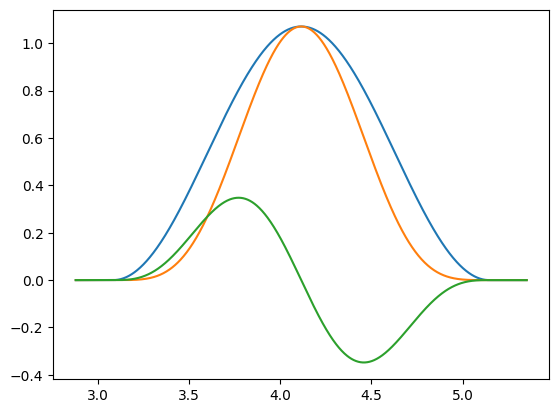

1.0708366263643523


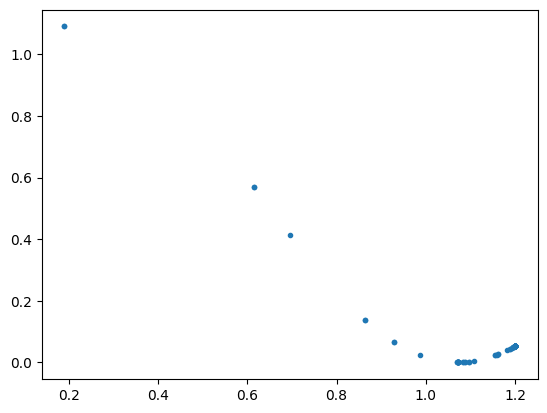

In [133]:
state1_pops = {}

#tlist = np.linspace(0, 5*t_g, 50)
sz, sx, sy = qt.sigmaz(), qt.sigmax(), qt.sigmay()
fund_11 = (qt.qeye(2) - sz)/2
fund_01 = (qt.sigmax()+1j*qt.sigmay())/2
fund_10 = (qt.sigmax()-1j*qt.sigmay())/2
announcedDeltat0 = True
loss_log = {}


Delta_t0 = -t_g/4*(1+omega_01/omega_d)
while Delta_t0 < 0: Delta_t0 += 2*np.pi/omega_d
tlist = np.linspace(Delta_t0-t_g*0.1, Delta_t0 + 1.1*t_g, 1000)
if tlist[0] < 0:
    tlist += 2*np.pi/omega_d
    Delta_t0 += 2*np.pi/omega_d
envelope_func = lambda t, Omega, Delta_t0, t_g: Omega*np.sin(np.pi*(t-Delta_t0)/t_g)**2 if (t > Delta_t0 and t < Delta_t0 + t_g) else 0
phase_log = {}
hbar = 1
Delta_varphi = 0# x gate
varphi = 0
t_0 = 0
def H_func(t):
    #phase_log[t] = -1j*hbar/4 * (1 + 1j*np.exp(-1j*Delta_varphi)+ np.exp(-2j*omega_d*t)*(1 + 1j*np.exp(1j*Delta_varphi)))
    #var = -1j*hbar/4 * (1 + 1j*np.exp(-1j*Delta_varphi)+ np.exp(-2j*omega_d*t)*(1 + 1j*np.exp(1j*Delta_varphi)))
    var = hbar*np.exp(1j*varphi)/2*(1+np.exp(-1j*((omega_01+omega_d)*(t-t_0) + 2*omega_d*t_0+2*varphi)))
    phase_log['H'][t] = var
    return var
glob_Omega = 1
glob_Delta_t0 = 0
def together_func(t):
    global glob_Omega
    var = H_func(t)*envelope_func(t, glob_Omega, glob_Delta_t0, t_g)
    phase_log['envelope'][t] = var
    return var

maxOmega = 1
def do_sim(Omega,t_g, Delta_t0,optimizeReturn=None, prepState=None):
    global tlist
    global fund_11
    global fund_01
    global fund_10
    global announcedDeltat0
    global loss_log
    global envelope_func
    global omega_01
    global omega_d
    global phase_log
    global glob_Omega
    global glob_Delta_t0
    global maxOmega
    glob_Omega = Omega
    glob_Delta_t0 = Delta_t0
    phase_log = {'H': {}, 'envelope': {}}
    
    if Omega > maxOmega: return 1e10*Omega
    if Omega < 0: return 1e10*(-Omega+1)
    #units
    #hbar = 1
    #[timeunit] = 1e-9 s
    #[frequnit] = 1e9 Hz
    #[energyunit] = 1e9 hbar Hz
    if prepState is None:
        psi0 = qt.basis(2,0)
    else:
        psi0 = prepState
    
    
    #Omega = np.sqrt(2)#*2*np.pi*0.1
    if omega_01 - omega_d == 0:
        H0 = qt.Qobj(0)
    else:
        H0 = qt.QobjEvo([fund_11,(omega_01-omega_d)])*hbar
    
    #H_func = lambda t: -1j*hbar/4 * (1 + 1j*np.exp(-1j*Delta_varphi)+ np.exp(-2j*omega_d*t)*(1 + 1j*np.exp(1j*Delta_varphi)))
    
    #Delta_t0 = 0
    if not announcedDeltat0: print(f"Setting Delta_t0 to {Delta_t0} as compared to t_g of {t_g}")
    
    if not announcedDeltat0: print("Changed Delta_t0 to", Delta_t0)
    
    
    if not announcedDeltat0:
        plt.clf()
        Y = np.zeros_like(tlist)
        for i,t in enumerate(tlist):
            Y[i] = envelope_func(t, Omega, Delta_t0, t_g)
        plt.plot(tlist,Y)
    
    if not announcedDeltat0:
        Y = np.zeros_like(tlist, dtype=complex)
        for i,t in enumerate(tlist):
            Y[i] = together_func(t)
        plt.plot(tlist, Y.real)
        plt.plot(tlist, Y.imag)
        plt.show()
    announcedDeltat0 = True
    H1 = qt.QobjEvo([fund_01, together_func])
    H_ = H1.dag()
    H1 = H1 + H_
    if omega_01 - omega_d == 0:
        H = H1
    else:
        H = H0 + H1
    #H = qt.QobjEvo([H0, H1])#), args={omega_d: omega_d, Omega: Omega, Delta_varphi: Delta_varphi})
    tlist_local = tlist[tlist > Delta_t0 - 0.1*t_g]
    solver = qt.SESolver(H, options={'nsteps':10000})
    result = solver.run(psi0, tlist_local)
    while len(result.states) < len(tlist):
        result.states.insert(0, result.states[0])
    #b = qt.Bloch()
    #b.add_states(result.states, kind='point', colors=['b']*len(result.states))
    #b.title = "Delta_varphi = " + str(Delta_varphi)
    #b.show()
    #state1_pops[Delta_varphi] = qt.expect(fund_11, result.states)
    #return qt.expect(fund_11, result.states)
    #return result.states
    #return the expectation value of the sigma_x operator
    if optimizeReturn == None: return result.states
    if "z" in optimizeReturn:
        #var = qt.expect(qt.sigmay(), result.states[-1])
        var = qt.expect(qt.sigmaz(), result.states[-1])
        if optimizeReturn == "z_abs": return var
        var = np.abs(var)**2 * (1+Omega)
        print(Omega, var)
        for O in Omega:
            loss_log[float(O)] = var
        return var
    elif optimizeReturn == "x":
        var = np.abs(qt.expect(qt.sigmax(), result.states[-1]))**2
        print(Delta_t0, var)
        loss_log[float(Omega)] = var
        return var
    else:
        return result.states

def do_sim_Omega(Omega, args):
    print(Omega)
    t_g, Delta_t0, optimizeMode, modifySampling = args
    if modifySampling: Omega = Omega**2
    return do_sim(Omega, t_g, Delta_t0, optimizeMode)

def do_sim_Deltat0(Delta_t0, args):
    print(Delta_t0)
    Omega, t_g, optimizeMode, modifySampling = args
    return do_sim(Omega, t_g, Delta_t0, optimizeMode)

multithread = True

"""Delta_varphi_space = np.linspace(0, 2*np.pi, 500)
if not multithread:
    for Delta_varphi in Delta_varphi_space:
        state1_pops[Delta_varphi] = do_sim(Delta_varphi)
else:
    from multiprocessing import Pool
    p = Pool(10)
    state1_pops = dict(zip(Delta_varphi_space, p.map(do_sim, Delta_varphi_space))
    )
    p.close()
    p.join()"""
from scipy.optimize import minimize, basinhopping
#optimize Omega such that the state is on the equator
#first do sweep of Omega to find zerocrossing of loss function
losess = []
for Omega in np.linspace(0, 1, 100):
    loss = do_sim(np.array([Omega]), t_g, Delta_t0, "z_abs")
    losess.append(loss)
    if len(losess) > 1 and losess[-2] > 0 and losess[-1] < 0:
        break
maxOmega = Omega*1.2

#optimize, but with a max omega of 10
res = basinhopping(do_sim_Omega, maxOmega, niter=2, minimizer_kwargs={'args':([t_g,Delta_t0,"z",False])}, T=1000)
#res = minimize(do_sim, 0.5, args=(t_g,True), bounds=[(0,100)], options={'maxiter': 1000})
Omega = res.x[0]
announcedDeltat0 = False
states = do_sim(Omega, t_g, Delta_t0)
print(Omega)
plt.clf()
plt.plot(loss_log.keys(), loss_log.values(), '.')
plt.show()


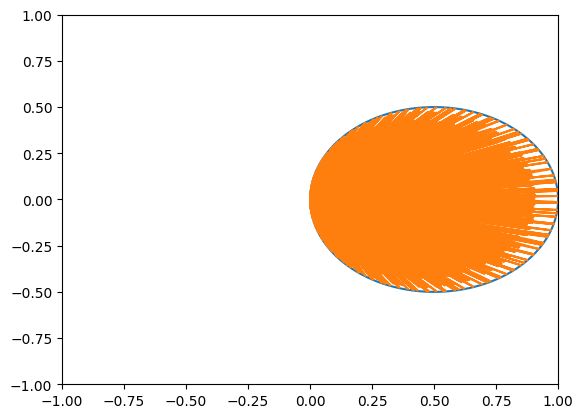

In [112]:
#do a complex plot of phase_log
plt.clf()

maxv = 0
def plot_phase(dictphase):
    global maxv
    global doPlt
    if not doPlt: return
    #normalize
    maxAbs = np.max(np.abs(list(dictphase.values())))
    for t in dictphase.keys():
        dictphase[t] /= maxAbs
    real = np.zeros(len(dictphase))
    imag = np.zeros(len(dictphase))
    #sort by angle on plane starting from pi/2
    
    for i,t in enumerate(dictphase.keys()):
        real[i] = dictphase[t].real
        imag[i] = dictphase[t].imag
        if np.abs(real[i]) > maxv: maxv = np.abs(real[i])
        if np.abs(imag[i]) > maxv: maxv = np.abs(imag[i])
    angles = np.arctan2(imag, real)
    sort = np.argsort(angles)
    real = real[sort]
    imag = imag[sort]
    plt.plot(real, imag)
plot_phase(phase_log['H'])
plot_phase(phase_log['envelope'])
plt.xlim([-maxv, maxv])
plt.ylim([-maxv, maxv])
plt.show()

In [113]:
#now minimize for Delta_t0
if False:
    #res = minimize(do_sim_Deltat0, Delta_t0, args=([Omega, t_g, "x"]), bounds=[(0, 10)])
    res = basinhopping(do_sim_Deltat0, Delta_t0, niter=2, minimizer_kwargs={'args':([Omega, t_g, "x"])}, T=1000)
    Delta_t0 = res.x[0]
    announcedDeltat0 = False
    states = do_sim(Omega, t_g, Delta_t0)
    print(Delta_t0)
    plt.clf()

In [114]:
#alternate between optimizing Omega and Delta_t0 a few times
if False:
    for i in range(10):
        res = minimize(do_sim_Omega, Omega, args=([t_g,Delta_t0,"z"]), bounds=[(0, 10)], options={'maxiter': 1000})
        Omega = res.x[0]
        res = minimize(do_sim_Deltat0, Delta_t0, args=([Omega, t_g, "x"]), bounds=[(0, 10)], options={'maxiter': 1000})
        Delta_t0 = res.x[0]
    announcedDeltat0 = False
    states = do_sim(Omega, t_g, Delta_t0)
    plt.plot(loss_log.keys(), loss_log.values(), '.')
    plt.show()

In [115]:
if doPlt:
    #animate the complex number of H_func as a function of time, and show a video of it
    #have it be a trailing line animation
    from matplotlib.animation import FuncAnimation
    from matplotlib import rc
    from IPython.display import display
    fig, ax = plt.subplots()
    #draw axis
    ax.axhline(0, color='black', lw=1)
    ax.axvline(0, color='black', lw=1)
    #have continually updated annotation
    anot = ax.annotate("", xy=(0.7, 0.8), xytext=(0, 0), textcoords="offset points", arrowprops=dict(arrowstyle="->"))
    line1, = ax.plot([], [], lw=2, label="delivered pulse [a.u.]", color='red')
    line2, = ax.plot([], [], lw=2, label="H_func", color='blue', linestyle='dashed')
    ax.legend()
    def init():
        ax.set_xlim(-maxv, maxv)
        ax.set_ylim(-maxv, maxv)
        return line1, line2
    cords1_real = []
    cords1_imag = []
    cords2_real = []
    cords2_imag = []
    maxVar = 0
    def update(frame):
        global maxVar
        print(".", end='')
        t = tlist[::5][frame]
        #print(t)
        var = H_func(t)*envelope_func(t, Omega, Delta_t0, t_g)/Omega
        cords1_real.append(var.real)
        cords1_imag.append(var.imag)
        if np.abs(var.real) > maxVar: maxVar = np.abs(var.real)
        if np.abs(var.imag) > maxVar: maxVar = np.abs(var.imag)
        line1.set_data(cords1_real, cords1_imag)
        var = H_func(t)
        cords2_real.append(var.real)
        cords2_imag.append(var.imag)
        if np.abs(var.real) > maxVar: maxVar = np.abs(var.real)
        if np.abs(var.imag) > maxVar: maxVar = np.abs(var.imag)
        line2.set_data(cords2_real, cords2_imag)
        anot.set_text(f"t = {t:.2f}")
        ax.set_xlim(-maxVar, maxVar)
        return line1,
    ani = FuncAnimation(fig, update, frames=range(100), init_func=init, blit=True)
    rc('animation', html='html5')
    display(ani)
    plt.clf()


....................................................................................................

<Figure size 640x480 with 0 Axes>

In [134]:
def plot_results(states, overWritedoPlt=False):
    global doPlt
    if not doPlt and not overWritedoPlt: return
    #plot the bloch sphere representation of the states and a line plot for the expectation value of sigma_x
    plt.clf()
    fig = plt.figure(constrained_layout=True, figsize=(10,3))
    ax1 = fig.add_subplot(121)
    
    exp_z = qt.expect(qt.sigmaz(), states)
    mask = exp_z < 1
    mask = mask & (abs(exp_z) > 1e-5)
    t_list_local = tlist[mask]
    ey, ex, ez = qt.expect(qt.sigmay(), states), qt.expect(qt.sigmax(), states), qt.expect(qt.sigmaz(), states)
    ax1.plot(t_list_local, ey[mask], label="Expectation value of sigma_y")
    ax1.plot(t_list_local, ez[mask], label="Expectation value of sigma_z")
    ax1.plot(t_list_local, ex[mask], label="Expectation value of sigma_x")
    ax1.legend()
    ax1.set_ylabel("Expectation value")
    ax1.set_xlabel("Time [ns]")
    
    ax2 = fig.add_subplot(122, projection='3d')
    b = qt.Bloch(fig=fig, axes=ax2)
    ax2.set_box_aspect([1,1,1])
    
    b.add_states(states, kind='point', colors=['b']*len(states))
    #b.title = "Final state" 
    b.save(dirc='tmp')
    b.show()

plot_results(states, overWritedoPlt=True)

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [117]:
def aces_gate(states, Omega, t_g):
    #print the angle of the final state on the equator
    print(f"Optimizer found an Omega of {Omega:.4f} to be needed for the given t_g of {t_g}ns")
    theta = np.arccos(-qt.expect(qt.sigmay(), states[-1]))
    print(f"State is {theta/np.pi:.3f}pi away from the desired -y state")
    print(f"State has a x expectation value of {qt.expect(qt.sigmax(), states[-1]):.3e}")
    print(f"State has a z expectation value of {qt.expect(qt.sigmaz(), states[-1]):.3e}")
    return theta
theta = aces_gate(states, Omega, t_g)

Optimizer found an Omega of 0.0100 to be needed for the given t_g of 20.5761316872428ns
State is 0.467pi away from the desired -y state
State has a x expectation value of -6.612e-06
State has a z expectation value of 9.947e-01


In [118]:
#do the virtual Z gate, linearly applied through the envelope
Z_theta = lambda phi: np.cos(phi/2)*qt.qeye(2) + 1j*np.sin(phi/2)*qt.sigmaz()
tenv = lambda t: (t-Delta_t0)/t_g if (t > Delta_t0) else 0
transformation_envelope = lambda t: tenv(t) if (t < Delta_t0 + t_g) else 1
Z_theta_t = lambda t: Z_theta(transformation_envelope(t)*theta)
for i, state in enumerate(states):
    states[i] = Z_theta(-transformation_envelope(tlist[i])*theta)*state
    pass
"""for i, state in enumerate(states):
    states[i] = Z_theta(theta)*state"""

'for i, state in enumerate(states):\n    states[i] = Z_theta(theta)*state'

In [119]:
plot_results(states)
aces_gate(states, Omega, t_g)

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [99]:
print("Finally found an Omega of", Omega, "and a Delta_t0 of", Delta_t0)

Finally found an Omega of 5.5495882516696325e-17 and a Delta_t0 of 6.1728395061728385


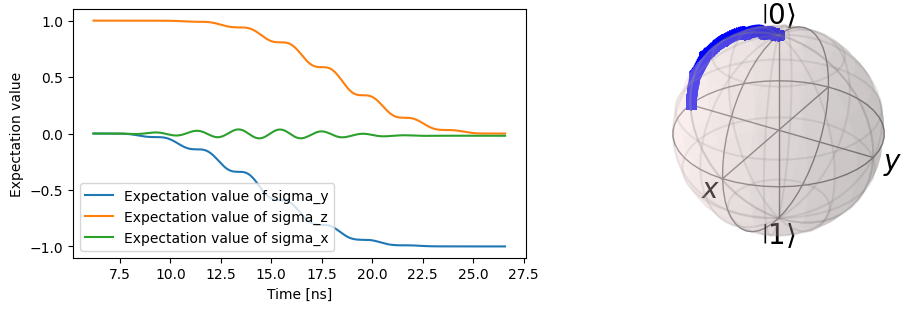

Optimizer found an Omega of 0.1528 to be needed for the given t_g of 20.5761316872428ns
State is 0.006pi away from the desired -y state
State has a x expectation value of -1.969e-02
State has a z expectation value of 6.659e-08
0.019686844801943243


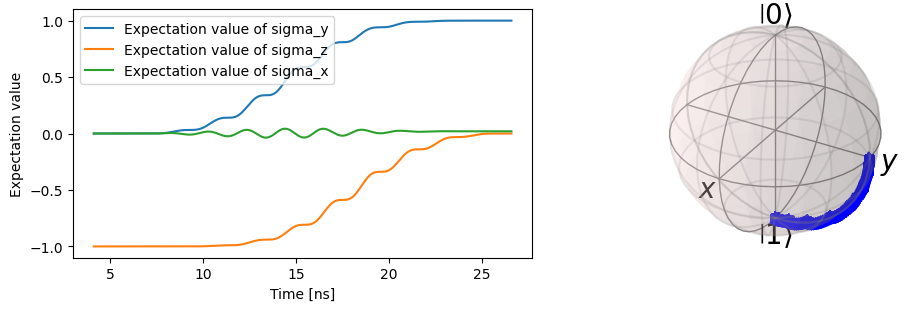

Optimizer found an Omega of 0.1528 to be needed for the given t_g of 20.5761316872428ns
State is 0.994pi away from the desired -y state
State has a x expectation value of 1.969e-02
State has a z expectation value of -6.659e-08
0.019686844801943243


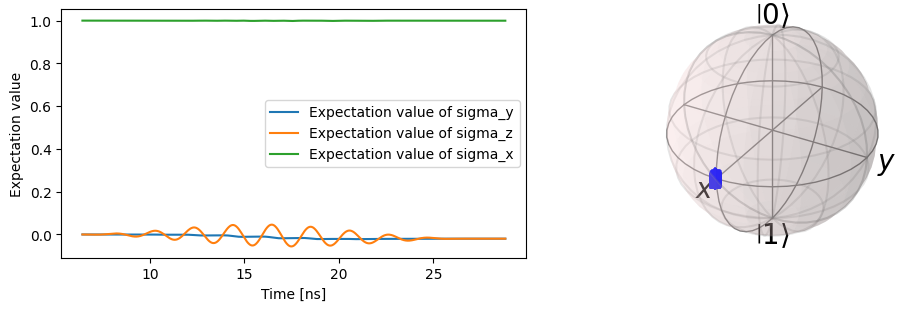

Optimizer found an Omega of 0.1528 to be needed for the given t_g of 20.5761316872428ns
State is 0.494pi away from the desired -y state
State has a x expectation value of 9.996e-01
State has a z expectation value of -1.968e-02
0.027840976886129475


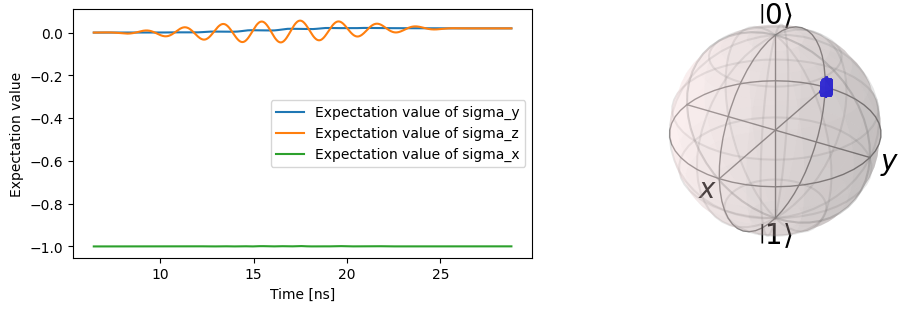

Optimizer found an Omega of 0.1528 to be needed for the given t_g of 20.5761316872428ns
State is 0.506pi away from the desired -y state
State has a x expectation value of -9.996e-01
State has a z expectation value of 1.968e-02
0.027840976886129475


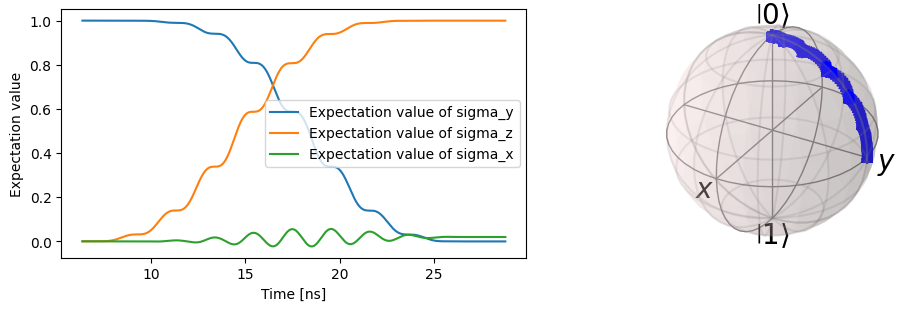

Optimizer found an Omega of 0.1528 to be needed for the given t_g of 20.5761316872428ns
State is 0.500pi away from the desired -y state
State has a x expectation value of 1.968e-02
State has a z expectation value of 9.998e-01
0.019689141796015306


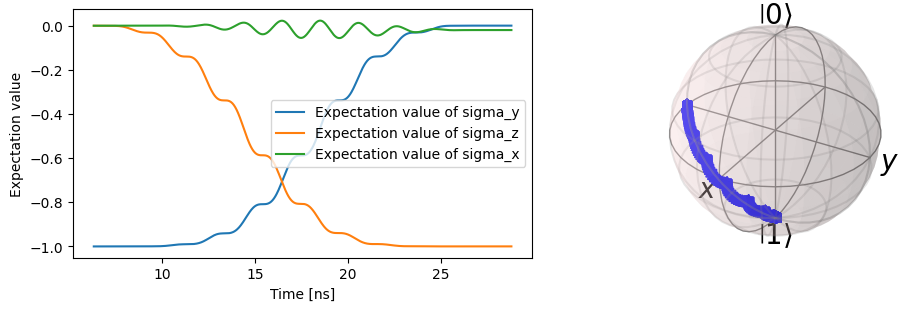

Optimizer found an Omega of 0.1528 to be needed for the given t_g of 20.5761316872428ns
State is 0.500pi away from the desired -y state
State has a x expectation value of -1.968e-02
State has a z expectation value of -9.998e-01
0.019689141796015306


<Figure size 640x480 with 0 Axes>

In [126]:
#use the found parameters to perform an X gate on various other states and check the fidelity
#log angle between final state and desired state
fidelityMeassures = []

prepState = qt.basis(2,0)
states = do_sim(Omega, t_g, Delta_t0, prepState=prepState)
plot_results(states)
aces_gate(states, Omega, t_g)
#fidelity = qt.fidelity((qt.basis(2,0)-1j*qt.basis(2,1)).unit(), states[-1])
fidelity = np.arccos(-qt.expect(qt.sigmay(), states[-1]))
fidelityMeassures.append(fidelity)
print(fidelity)

prepState = qt.basis(2,1)
states = do_sim(Omega, t_g, Delta_t0, prepState=prepState)
plot_results(states)
aces_gate(states, Omega, t_g)
#fidelity = qt.fidelity((qt.basis(2,0)+1j*qt.basis(2,1)).unit(), states[-1])
fidelity = np.arccos(qt.expect(qt.sigmay(), states[-1]))
fidelityMeassures.append(fidelity)
print(fidelity)

prepState = (qt.basis(2,0)+qt.basis(2,1)).unit()
states = do_sim(Omega, t_g, Delta_t0, prepState=prepState)
plot_results(states)
aces_gate(states, Omega, t_g)
#fidelity = qt.fidelity((qt.basis(2,0)+qt.basis(2,1)).unit(), states[-1])
#instead do dot by arccos of the dot product
fidelity = np.arccos(qt.expect(qt.sigmax(), states[-1]))
fidelityMeassures.append(fidelity)
print(fidelity)

prepState = (qt.basis(2,0)-qt.basis(2,1)).unit()
states = do_sim(Omega, t_g, Delta_t0, prepState=prepState)
plot_results(states)
aces_gate(states, Omega, t_g)
#fidelity = qt.fidelity((qt.basis(2,0)-qt.basis(2,1)).unit(), states[-1])
fidelity = np.arccos(qt.expect(-qt.sigmax(), states[-1]))
fidelityMeassures.append(fidelity)
print(fidelity)

prepState = (qt.basis(2,0)+1j*qt.basis(2,1)).unit()
states = do_sim(Omega, t_g, Delta_t0, prepState=prepState)
plot_results(states)
aces_gate(states, Omega, t_g)
#fidelity = qt.fidelity(qt.basis(2,0), states[-1])
fidelity = np.arccos(qt.expect(qt.sigmaz(), states[-1]))
fidelityMeassures.append(fidelity)
print(fidelity)

prepState = (qt.basis(2,0)-1j*qt.basis(2,1)).unit()
states = do_sim(Omega, t_g, Delta_t0, prepState=prepState)
plot_results(states)
aces_gate(states, Omega, t_g)
#fidelity = qt.fidelity(qt.basis(2,1), states[-1])
fidelity = np.arccos(-qt.expect(qt.sigmaz(), states[-1]))
fidelityMeassures.append(fidelity)
print(fidelity)


In [136]:
print("Fidelity meassures:", fidelityMeassures)
import pickle
import os
#pickle it to do logs on performance
"""if not os.path.exists("fid_logs.pickle"):
    logs = {}
    with open("fid_logs.pickle", "wb") as f:
        pickle.dump(logs, f)
with open("fid_logs.pickle", "rb") as f:
    logs = pickle.load(f)
logs[t_g/tau] = fidelityMeassures
with open("fid_logs.pickle", "wb") as f:
    pickle.dump(logs, f)
print("Saved to logs")"""
#instead, save to a tmp file with PID
path = f"tmp/fid_logs_{os.getpid()}.txt"
#path = os.path.join(os.path.dirname(__file__), path)
with open(path, "w") as f:
    f.write(f"{t_g/tau} {fidelityMeassures}\n")
print("Saved to logs")

Fidelity meassures: [np.float64(0.019686844801943243), np.float64(0.019686844801943243), np.float64(0.027840976886129475), np.float64(0.027840976886129475), np.float64(0.019689141796015306), np.float64(0.019689141796015306)]
Saved to logs
